In [1]:
# !pip install nest_asyncio
# !pip install scipy
# !pip install pandas
# !pip install seaborn

In [2]:
# imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from helper import generate_schedule, is_notebook, deribitExp2Dt
from options import Option, OptionPortfolio, BullishStrategy
import datetime as dt
from deribit import client
import ipywidgets as widgets
from IPython.display import display, clear_output
import nest_asyncio
nest_asyncio.apply()

In [19]:
# Initialize an empty portoflio
ptf = OptionPortfolio()

# Initialize instruments lists and default values
indices = {'ETH': ('eth_usd', 'ETH'), 'BTC': ('btc_usd', 'BTC')}
futures = []
options = []
for index in indices:
    options.append(client.download_instr_data(index, 'option'))
    futures.append(client.download_instr_data(index, 'future'))
options_df = pd.concat(options)
futures_df = pd.concat(futures)


# Initialize the output
output = {}
output['Strategy'] = widgets.Output()
for index in indices:
    output[index] = widgets.Output()
# output['plot'] = widgets.Output()

In [22]:
# Download from Deribit the current expiry dates
fut_exp = client.get_fut_exp(futures_df, indices[list(indices.keys())[0]][0])

# Download the available strikes with the selected expiry date
strikes = client.get_strike(options_df, indices[list(indices.keys())[0]][0], 'call', fut_exp[0])

# Create a droplist to select the underlying (ETH or BTC)
index_selection = widgets.Dropdown(options=list(indices.keys()),
                                   value=list(indices.keys())[0],
                                   description='Index',
                                   disabled=False)

# Create a droplist to select the option type (buy or sell)
side_selection = widgets.Dropdown(options=['buy', 'sell'],
                                  value='buy',
                                  description='Side',
                                  disabled=False)

# Create a input boxt to enter the notional
size_selection = widgets.BoundedFloatText(
                value=1.0,
                min=0,
                max=99999999999999999999999999999999999.0,
                step=0.5,
                description='Size:',
                disabled=False
                )                         

# Create a droplist to select the option type (call or put)
opt_type_selection = widgets.Dropdown(options=['call', 'put'],
                                      value='call',
                                      description='Type',
                                      disabled=False)

# Create dropdown widget with the Deribit expiry dates
exp_selection = widgets.Dropdown(options=fut_exp,
                                 value=fut_exp[0],
                                 description='Expiry',
                                 disabled=False)

# Create dropdown widget with the Deribit strikes
strike_selection = widgets.Dropdown(options=strikes,
                                    value=strikes[0],
                                    description='Strike',
                                    disabled=False)

# Create the add button object
add_opt_btn = widgets.Button(
              description='Add',
              disabled=False,
              button_style='', # 'success', 'info', 'warning', 'danger' or ''
              tooltip='Add an option to the strategy',
              icon='fa-plus'
              )

# Create the reset button object
reset_btn = widgets.Button(
            description='Reset',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Reset the strategy',
            icon=''
            )  

# Update the strikes list
def update_strikes():
    global strikes
    undl = indices[index_selection.value][0]
    strikes = client.get_strike(options_df, undl, 'call', exp_selection.value)

# Update the expiry dates
def update_futures_exp():
    global fut_exp
    undl = indices[index_selection.value][0]
    fut_exp = client.get_fut_exp(futures_df, undl)
    
# Trigger the update the strikes list when the expiry date changes
def on_change_expiry(_):
    #global exp_selection
    update_strikes()
    strike_selection.options=strikes
    strike_selection.value=strikes[0]

# Trigger the update of all the fields when the index is changed
def on_change_index(_):
    update_futures_exp()
    exp_selection.options=fut_exp
    exp_selection.value=fut_exp[0]    
    update_strikes()
    strike_selection.options=strikes
    strike_selection.value=strikes[0]
    side_selection.value = 'buy'
    size_selection.value = 1.0
    
# Reset the strategy
def reset(_):
    global ptf
    ptf = OptionPortfolio()
    for index in indices:
        output[index].clear_output()
    output['plot'].clear_output()    
    update_output()

# Add an option to the stragegy
def add(b):
    global ptf
    undl = indices[index_selection.value][0]
    undl = undl[0:3] + '-' + undl[-3:]
    k = strike_selection.value
    exp = deribitExp2Dt(exp_selection.value)
    opt_type = opt_type_selection.value
    size = float(size_selection.value)
    side = side_selection.value
    opt = Option(undl, opt_type, k, exp, size, side)
    ptf.add(opt)
    update_output()
    
def update_output():
    price = ptf.deribit_price()
    with output['Strategy']:
        display(ptf.to_df, clear=True)
    for index in ptf.unique_undls:
        tmp = index[:3].upper()
        key = indices[index[:3].upper()][0].replace('_', '-')
        with output[tmp]:
            display(pd.DataFrame.from_dict(price[key]), clear=True)
#     with output['plot']:
#         display(ptf.plot(indices[index[:3].upper()][0].replace('_', '-')), clear = True)

# Create a display VBox
index_label = widgets.Label(value='Index') 
side_label = widgets.Label(value='Direction')
size_label = widgets.Label(value='Size')
exp_label = widgets.Label(value='Expiry')
opt_type_label = widgets.Label(value='Type')
strike_label = widgets.Label(value='Strike')

# Setting up the box layout
box_layout = widgets.Layout(display='flex',
                            flex_flow='column',
                            align_items='flex-end',
                            width='33%')

items = [index_selection,
         side_selection,
         size_selection,
         exp_selection,
         opt_type_selection,
         strike_selection,
         add_opt_btn,
         reset_btn]

# Create observers
index_selection.observe(on_change_index, names='value')
exp_selection.observe(on_change_expiry, names='value')
add_opt_btn.on_click(add)
reset_btn.on_click(reset)

# Create controls display
controls_label = widgets.Label('Option Selector')
controls = widgets.VBox(children=items, layout=box_layout)

# Create tabs. One tab per underlying available and one tab for the overall strategy
tab_label = widgets.Label('Strategy Analytics')
tab_nest = widgets.Tab()
tab_children = [output['Strategy']]
tab_titles = ['Strategy']

for index in indices:
    tab_children.append(output[index])
    tab_titles.append('Analytics (' + index + ')')
    
tab_nest.children = tab_children
for title, (index, _) in zip(tab_titles, enumerate(tab_nest.children)):
    tab_nest.set_title(index, title)
    
tabs = widgets.VBox([tab_label, tab_nest])

# Create the plot display
plot_label = widgets.Label('Plot')

Label(value='Option Selector')

Label(value='Plot')

Output()

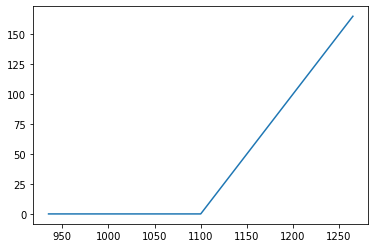

In [23]:
display(controls_label)
display(controls)
display(tabs)